# Importation des bibliothèques

In [2]:
import sys
sys.path.insert(0, '..')

In [29]:
%load_ext autoreload
%autoreload 2
from modele import Module_lineare
from loss  import MSELoss
import non_lineaire as nl
import numpy as np
import matplotlib.pyplot as plt
import math
import utils as ut

from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Génération de données aléatoires

In [11]:
# Test de l'implémentation
# Génération de données pour la classification binaire
X = np.random.randn(1000, 2)
y = np.random.randint(2, size=1000)  # Classes binaires (0 et 1)

y = y.reshape(-1, 1)

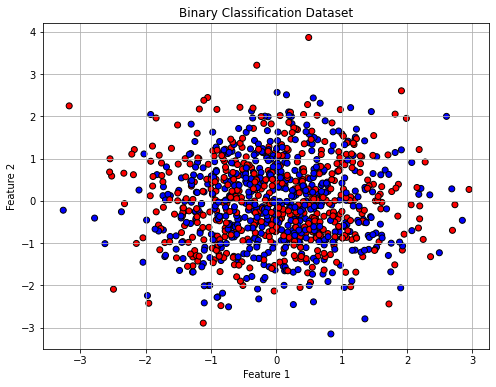

In [5]:
# Affichage des données
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', marker='o', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Dataset')
plt.grid(True)
plt.show()

### Lineneairement séparables :

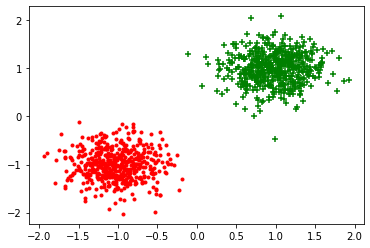

In [147]:
data, y = ut.gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.02)
data, y = ut.gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02)
y = np.where(y==-1,0,1).reshape((-1,1))


ut.plot_data(data,y)

Train : (800, 2)
Test : (200, 2)
Epoch 1, Loss: 0.7463917741826229
Epoch 2, Loss: 0.7452661762119857
Epoch 3, Loss: 0.7441333412748024
Epoch 4, Loss: 0.7429932252729534
Epoch 5, Loss: 0.7418457841394601
Epoch 6, Loss: 0.7406909738490748
Epoch 7, Loss: 0.7395287504291735
Epoch 8, Loss: 0.7383590699709562
Epoch 9, Loss: 0.7371818886409561
Epoch 10, Loss: 0.7359971626928687
Epoch 11, Loss: 0.7348048484796995
Epoch 12, Loss: 0.7336049024662381
Epoch 13, Loss: 0.7323972812418639
Epoch 14, Loss: 0.7311819415336862
Epoch 15, Loss: 0.7299588402200247
Epoch 16, Loss: 0.7287279343442334
Epoch 17, Loss: 0.727489181128874
Epoch 18, Loss: 0.7262425379902423
Epoch 19, Loss: 0.7249879625532515
Epoch 20, Loss: 0.723725412666677
Epoch 21, Loss: 0.7224548464187659
Epoch 22, Loss: 0.7211762221532172
Epoch 23, Loss: 0.7198894984855326
Epoch 24, Loss: 0.7185946343197455
Epoch 25, Loss: 0.7172915888655288
Epoch 26, Loss: 0.7159803216556858
Epoch 27, Loss: 0.7146607925640276
Epoch 28, Loss: 0.713332961823638

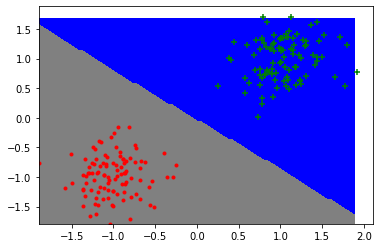

In [161]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)
print('Train :', X_train.shape)
print('Test :', X_test.shape)


module1 = Module_lineare(input_size=2, output_size=3)
activation_tanh = nl.TanH()
module2 = Module_lineare(input_size=3, output_size=1)
activation_sigmoide = nl.Sigmoide()

loss = MSELoss()
learning_rate = 0.01

train_losses = []
test_losses = []
test_accuracies = []
best_params_module1 = None
best_params_module2 = None
loss_min = math.inf

nb_epochs = 1000

for epoch in range(nb_epochs):


    # Forward pass

    # Passe avant (forward pass)
    output1 = module1.forward(X_train)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_train = loss.forward(y_train, output2_activated)
    train_losses.append(np.mean(loss_train))

    # Backward pass
    gradient_loss = loss.backward(y_train, output2_activated)
    
    delta_sig = activation_sigmoide.backward_delta(output2, gradient_loss)

    delta_linear_mod1 = module2.backward_delta(output1_activated, delta_sig)

    delta_tanh = activation_tanh.backward_delta(output1, delta_linear_mod1)

    delta_linear_mod1 = module1.backward_delta(X_train, delta_tanh)
    
    module2.backward_update_gradient(output1_activated, delta_sig)
    module1.backward_update_gradient(X_train, delta_tanh)


    # Mise à jour des paramètres
    module1.update_parameters(learning_rate)
    module2.update_parameters(learning_rate)

    if np.mean(loss_train) < np.mean(loss_min) :
        best_params_module1 = module1.get_parameters()
        best_params_module2 = module2.get_parameters()
        loss_min = np.mean(loss_train)
    else :
        module1.set_parameters(best_params_module1)
        module2.set_parameters(best_params_module2)


    # Test accuracy

    output1 = module1.forward(X_test)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_test = loss.forward(y_test, output2_activated)
    test_losses.append(np.mean(loss_test))

    y_pred = np.where(output2_activated >=0.5, 1, 0)

    accuracy = len(np.where(y_test == y_pred)[0])/len(y_pred)
    # accuracy =  np.where(y_test ==y_pred)[0].mean()
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {np.mean(loss_train)}")
    module1.zero_grad()
    module2.zero_grad()

def predict(x):
    hidden_l = module1.forward(x)
    hidden_l = activation_tanh.forward(hidden_l)
    hidden_l = module2.forward(hidden_l)
    hidden_l = activation_sigmoide.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

ut.plot_frontiere(X_test, predict, step=100)
ut.plot_data(X_test, y_test.reshape(-1))

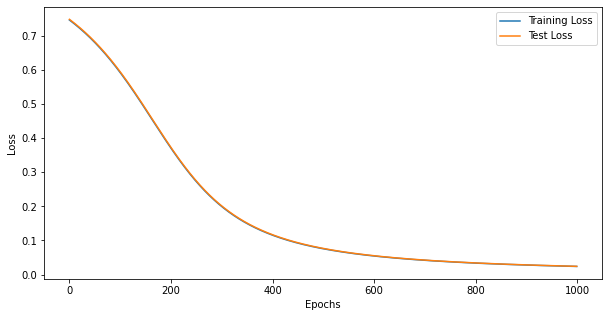

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

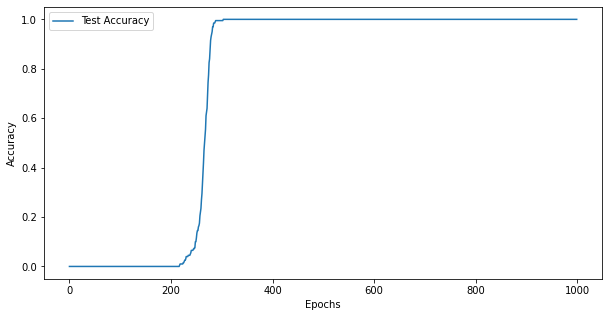

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Non separables lineairement:

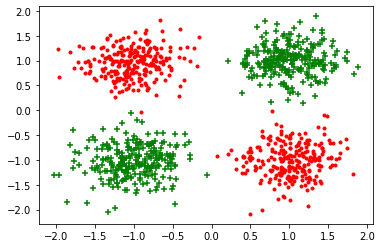

In [164]:
data, y = ut.gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.02)
y = np.where(y==-1,0,1).reshape((-1,1))


ut.plot_data(data,y)

Train : (800, 2)
Test : (200, 2)
Epoch 1, Loss: 0.37959686901357875
Epoch 2, Loss: 0.37831879998106116
Epoch 3, Loss: 0.3775584484571597
Epoch 4, Loss: 0.37708008617958844
Epoch 5, Loss: 0.37674978076368904
Epoch 6, Loss: 0.37649520791776653
Epoch 7, Loss: 0.37627836019247424
Epoch 8, Loss: 0.37607954186176284
Epoch 9, Loss: 0.3758886077934114
Epoch 10, Loss: 0.3757003317558555
Epoch 11, Loss: 0.375512002259279
Epoch 12, Loss: 0.37532218703901177
Epoch 13, Loss: 0.3751301016924501
Epoch 14, Loss: 0.3749352881042877
Epoch 15, Loss: 0.3747374509576563
Epoch 16, Loss: 0.3745363746699064
Epoch 17, Loss: 0.37433188115471777
Epoch 18, Loss: 0.37412380827218
Epoch 19, Loss: 0.3739119987435636
Epoch 20, Loss: 0.37369629434770374
Epoch 21, Loss: 0.37347653277371123
Epoch 22, Loss: 0.37325254580099154
Epoch 23, Loss: 0.37302415813374773
Epoch 24, Loss: 0.372791186548979
Epoch 25, Loss: 0.37255343918463896
Epoch 26, Loss: 0.3723107148792279
Epoch 27, Loss: 0.3720628025167645
Epoch 28, Loss: 0.371

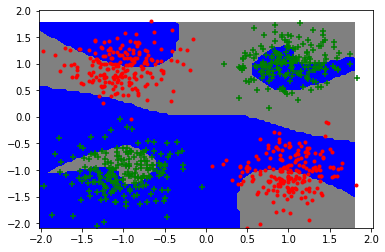

In [188]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)
print('Train :', X_train.shape)
print('Test :', X_test.shape)


module1 = Module_lineare(input_size=2, output_size=5)
activation_tanh = nl.TanH()
module2 = Module_lineare(input_size=5, output_size=1)
activation_sigmoide = nl.Sigmoide()

loss = MSELoss()
learning_rate = 0.1

train_losses = []
test_losses = []
test_accuracies = []
best_params_module1 = None
best_params_module2 = None
loss_min = math.inf

nb_epochs = 500

for epoch in range(nb_epochs):

    module1.zero_grad()
    module2.zero_grad()
    # Forward pass

    # Passe avant (forward pass)
    output1 = module1.forward(X_train)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_train = loss.forward(y_train, output2_activated)
    train_losses.append(np.mean(loss_train))

    # Backward pass
    gradient_loss = loss.backward(y_train, output2_activated)
    
    delta_sig = activation_sigmoide.backward_delta(output2, gradient_loss)

    delta_linear_mod1 = module2.backward_delta(output1_activated, delta_sig)

    delta_tanh = activation_tanh.backward_delta(output1, delta_linear_mod1)

    delta_linear_mod1 = module1.backward_delta(X_train, delta_tanh)
    
    module2.backward_update_gradient(output1_activated, delta_sig)
    module1.backward_update_gradient(X_train, delta_tanh)


    # Mise à jour des paramètres
    module1.update_parameters(learning_rate)
    module2.update_parameters(learning_rate)

    if np.mean(loss_train) < np.mean(loss_min) :
        best_params_module1 = module1.get_parameters()
        best_params_module2 = module2.get_parameters()
        loss_min = np.mean(loss_train)
    else :
        module1.set_parameters(best_params_module1)
        module2.set_parameters(best_params_module2)


    # Test accuracy

    output1 = module1.forward(X_test)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_test = loss.forward(y_test, output2_activated)
    test_losses.append(np.mean(loss_test))

    y_pred = np.where(output2_activated >=0.5, 1, 0)

    accuracy = len(np.where(y_test == y_pred)[0])/len(y_pred)
    # accuracy =  np.where(y_test ==y_pred)[0].mean()
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {np.mean(loss_train)}")


def predict(x):
    hidden_l = module1.forward(x)
    hidden_l = activation_tanh.forward(hidden_l)
    hidden_l = module2.forward(hidden_l)
    hidden_l = activation_sigmoide.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

ut.plot_frontiere(X_train, predict, step=100)
ut.plot_data(X_train, y_train.reshape(-1))

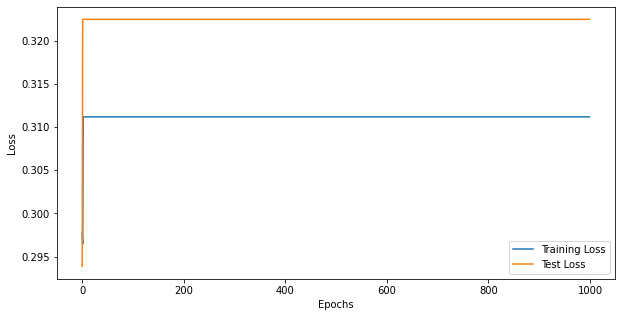

In [178]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

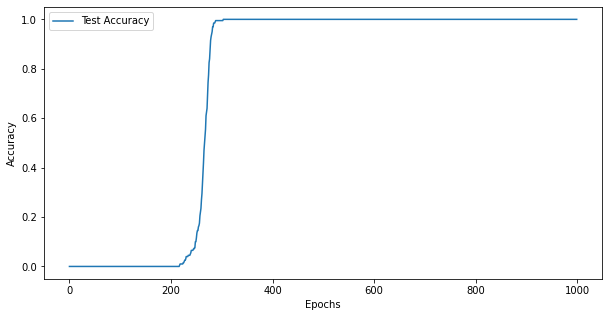

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [135]:

def predict(x):
    module1 = Module_lineare(input_size=2, output_size=30)
    activation_tanh = nl.TanH()
    module2 = Module_lineare(input_size=30, output_size=1)
    activation_sigmoide = nl.Sigmoide()
    hidden_l = module1.forward(x)
    hidden_l = activation_tanh.forward(hidden_l)
    hidden_l = module2.forward(hidden_l)
    hidden_l = activation_sigmoide.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)


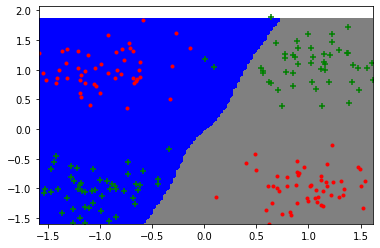

In [143]:
ut.plot_frontiere(X_test, predict, step=100)
ut.plot_data(X_test, y_test.reshape(-1))

In [174]:
import itertools
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)
print('Train :', X_train.shape)
print('Test :', X_test.shape)

# Définition des paramètres pour la recherche par grille
hidden_sizes = [5,20, 30, 40,50,100]  # Valeurs possibles pour le nombre de neurones dans la couche cachée
nb_epochs = [500,5000, 10000, 15000]  # Valeurs possibles pour le nombre d'époques
learning_rates = [0.0001,0.001, 0.01, 0.1]  # Valeurs possibles pour le taux d'apprentissage
output_size = 1  # Taille de la sortie

best_accuracy = 0
best_params = {}

# Boucle sur toutes les combinaisons de paramètres
for hidden_size, epoch,learning_rate in itertools.product(hidden_sizes, nb_epochs,learning_rates):
    # Création du modèle avec les paramètres actuels
    module1 = Module_lineare(input_size=2, output_size=hidden_size)
    activation_tanh = nl.TanH()
    module2 = Module_lineare(input_size=hidden_size, output_size=output_size)
    activation_sigmoide = nl.Sigmoide()

    # Définition de la fonction de perte et du taux d'apprentissage
    loss = MSELoss()

    train_losses = []

    # Entraînement du modèle
    for epoch in range(epoch):
        # Forward pass
        output1 = module1.forward(X_train)
        output1_activated = activation_tanh.forward(output1)
        output2 = module2.forward(output1_activated)
        output2_activated = activation_sigmoide.forward(output2)

        loss_train = loss.forward(y_train, output2_activated)
        train_losses.append(np.mean(loss_train))

        # Backward pass
        gradient_loss = loss.backward(y_train, output2_activated)

        delta_sig = activation_sigmoide.backward_delta(output2, gradient_loss)
        delta_linear_mod1 = module2.backward_delta(output1_activated, delta_sig)
        delta_tanh = activation_tanh.backward_delta(output1, delta_linear_mod1)
        delta_linear_mod1 = module1.backward_delta(X_train, delta_tanh)

        module2.backward_update_gradient(output1_activated, delta_sig)
        module1.backward_update_gradient(X_train, delta_tanh)

        # Mise à jour des paramètres
        module1.update_parameters(learning_rate)
        module2.update_parameters(learning_rate)

    # Test accuracy
    output1 = module1.forward(X_test)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    y_pred = np.where(output2_activated >= 0.5, 1, 0)
    accuracy = np.mean(y_pred == y_test)

    print(f"Hidden size: {hidden_size}, Epochs: {epoch}, Accuracy: {accuracy}")

    # Sauvegarde des meilleurs paramètres
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'acc':best_accuracy,'hidden_size': hidden_size, 'epochs': epoch,'learning rate': learning_rate}

print("Best parameters:", best_params)


Train : (800, 2)
Test : (200, 2)
Hidden size: 5, Epochs: 499, Accuracy: 0.495
Hidden size: 5, Epochs: 499, Accuracy: 0.455
Hidden size: 5, Epochs: 499, Accuracy: 0.49
Hidden size: 5, Epochs: 499, Accuracy: 0.555
Hidden size: 5, Epochs: 4999, Accuracy: 0.49
Hidden size: 5, Epochs: 4999, Accuracy: 0.54
Hidden size: 5, Epochs: 4999, Accuracy: 0.45
Hidden size: 5, Epochs: 4999, Accuracy: 0.45
Hidden size: 5, Epochs: 9999, Accuracy: 0.49
Hidden size: 5, Epochs: 9999, Accuracy: 0.45
Hidden size: 5, Epochs: 9999, Accuracy: 0.515
Hidden size: 5, Epochs: 9999, Accuracy: 0.465
Hidden size: 5, Epochs: 14999, Accuracy: 0.47
Hidden size: 5, Epochs: 14999, Accuracy: 0.485
Hidden size: 5, Epochs: 14999, Accuracy: 0.525
Hidden size: 5, Epochs: 14999, Accuracy: 0.45
Hidden size: 20, Epochs: 499, Accuracy: 0.465
Hidden size: 20, Epochs: 499, Accuracy: 0.48
Hidden size: 20, Epochs: 499, Accuracy: 0.465
Hidden size: 20, Epochs: 499, Accuracy: 0.46
Hidden size: 20, Epochs: 4999, Accuracy: 0.46
Hidden size:

/home/djeghali/M1DAC/S2/ML/PROJET/ML_Reseau_de_Neurone/Test/../non_lineaire.py:38: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/djeghali/M1DAC/S2/ML/PROJET/ML_Reseau_de_Neurone/Test/../utils.py:86: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Hidden size: 30, Epochs: 14999, Accuracy: 0.54
Hidden size: 40, Epochs: 499, Accuracy: 0.49
Hidden size: 40, Epochs: 499, Accuracy: 0.49
Hidden size: 40, Epochs: 499, Accuracy: 0.45
Hidden size: 40, Epochs: 499, Accuracy: 0.425
Hidden size: 40, Epochs: 4999, Accuracy: 0.45
Hidden size: 40, Epochs: 4999, Accuracy: 0.44
Hidden size: 40, Epochs: 4999, Accuracy: 0.45
Hidden size: 40, Epochs: 4999, Accuracy: 0.525
Hidden size: 40, Epochs: 9999, Accuracy: 0.51
Hidden size: 40, Epochs: 9999, Accuracy: 0.495
Hidden size: 40, Epochs: 9999, Accuracy: 0.445
Hidden size: 40, Epochs: 9999, Accuracy: 0.485
Hidden size: 40, Epochs: 14999, Accuracy: 0.485
Hidden size: 40, Epochs: 14999, Accuracy: 0.455
Hidden size: 40, Epochs: 14999, Accuracy: 0.53
Hidden size: 40, Epochs: 14999, Accuracy: 0.455
Hidden size: 50, Epochs: 499, Accuracy: 0.505
Hidden size: 50, Epochs: 499, Accuracy: 0.505
Hidden size: 50, Epochs: 499, Accuracy: 0.55
Hidden size: 50, Epochs: 499, Accuracy: 0.48
Hidden size: 50, Epochs: 49